# EDA

In [ ]:
# PySpark: Load and display schema for Walmart Retail Forecasting data
import os
os.environ["HADOOP_USER_NAME"] = "testuser"  # Add this line before Spark import

from pyspark.sql import SparkSession

data_dir = os.path.join(os.getcwd(), "data")

spark = SparkSession.builder.appName("WalmartRetailForecasting").getOrCreate()

# Load CSVs
df_train = spark.read.csv(os.path.join(data_dir, "train.csv", "train.csv"), header=True, inferSchema=True)
df_features = spark.read.csv(os.path.join(data_dir, "features.csv", "features.csv"), header=True, inferSchema=True)
df_stores = spark.read.csv(os.path.join(data_dir, "stores.csv"), header=True, inferSchema=True)

print("Train schema:")
df_train.printSchema()
print("Features schema:")
df_features.printSchema()
print("Stores schema:")
df_stores.printSchema()

spark.stop()

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.UnsupportedOperationException: getSubject is not supported
	at java.base/javax.security.auth.Subject.getSubject(Subject.java:277)
	at org.apache.hadoop.security.UserGroupInformation.getCurrentUser(UserGroupInformation.java:588)
	at org.apache.spark.util.Utils$.$anonfun$getCurrentUserName$1(Utils.scala:2446)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.util.Utils$.getCurrentUserName(Utils.scala:2446)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:339)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:62)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1447)


In [ ]:
import pandas as pd
import os

# Create outputs folder
output_dir = os.path.join(os.getcwd(), "outputs")
os.makedirs(output_dir, exist_ok=True)
print(f"Outputs will be saved to: {output_dir}")

# Load datasets
data_dir = os.path.join(os.getcwd(), "data")
train = pd.read_csv(os.path.join(data_dir, "train.csv", "train.csv"))
features = pd.read_csv(os.path.join(data_dir, "features.csv", "features.csv"))
stores = pd.read_csv(os.path.join(data_dir, "stores.csv"))

# Merge datasets
df = train.merge(features, on=["Store", "Date"], how="left")
df = df.merge(stores, on="Store", how="left")

# Convert date to datetime

df["Date"] = pd.to_datetime(df["Date"])df.head()

print(df.shape)
# Preview

(421570, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


## Data Validation & Quality Checks

In [ ]:
"""
Data Validation Layer
Performs pre-processing validation to ensure data quality and pipeline integrity
"""

print("=" * 60)
print("DATA VALIDATION CHECKS")
print("=" * 60)

# 1. Schema Validation
print("\n1. SCHEMA VALIDATION")
print("-" * 40)
expected_train_cols = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
expected_features_cols = ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 
                         'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
                         'CPI', 'Unemployment', 'IsHoliday']
expected_stores_cols = ['Store', 'Type', 'Size']

assert list(train.columns) == expected_train_cols, "Train schema mismatch"
assert list(stores.columns) == expected_stores_cols, "Stores schema mismatch"
print("✓ Train schema validated")
print("✓ Features schema validated")
print("✓ Stores schema validated")

# 2. Row Count Validation
print("\n2. ROW COUNT VALIDATION")
print("-" * 40)
train_rows = len(train)
features_rows = len(features)
stores_rows = len(stores)
df_rows = len(df)

print(f"Train rows: {train_rows:,}")
print(f"Features rows: {features_rows:,}")
print(f"Stores rows: {stores_rows:,}")
print(f"Merged dataset rows: {df_rows:,}")

# Validate join did not explode rows
assert df_rows == train_rows, f"Row count mismatch after merge. Expected {train_rows}, got {df_rows}"
print("✓ Join integrity validated (no row explosion)")

# 3. Null Value Check for Critical Columns
print("\n3. NULL VALUE VALIDATION")
print("-" * 40)
critical_columns = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size']
null_counts = df[critical_columns].isnull().sum()
print("Null counts in critical columns:")
for col in critical_columns:
    count = null_counts[col]
    status = "✓" if count == 0 else "⚠"
    print(f"  {status} {col}: {count}")

assert df['Weekly_Sales'].isnull().sum() == 0, "Weekly_Sales contains null values"
print("✓ Weekly_Sales has no nulls")

# 4. Date Parsing Validation
print("\n4. DATE PARSING VALIDATION")
print("-" * 40)
assert df['Date'].dtype == 'datetime64[ns]', "Date column not properly parsed"
print(f"✓ Date column parsed as datetime")
print(f"  Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"  Total weeks: {df['Date'].nunique()}")

# 5. Data Quality Checks
print("\n5. DATA QUALITY CHECKS")
print("-" * 40)

# Check for negative sales
negative_sales = (df['Weekly_Sales'] < 0).sum()
print(f"  Negative Weekly_Sales: {negative_sales}")

# Check for duplicate Store-Dept-Date combinations
duplicates = df.duplicated(subset=['Store', 'Dept', 'Date']).sum()
print(f"  Duplicate Store-Dept-Date: {duplicates}")
assert duplicates == 0, "Found duplicate Store-Dept-Date combinations"
print("✓ No duplicates in Store-Dept-Date")

# Store distribution
print(f"  Unique Stores: {df['Store'].nunique()}")
print(f"  Unique Departments: {df['Dept'].nunique()}")
print(f"  Store Types: {df['Type'].value_counts().to_dict()}")

print("\n" + "=" * 60)
print("VALIDATION COMPLETE - PIPELINE READY")
print("=" * 60)

print(f"\n✓ Validation report saved to: {os.path.join(output_dir, 'validation_report.txt')}")

# Save validation report    f.write(validation_report)

validation_report = f"""with open(os.path.join(output_dir, 'validation_report.txt'), 'w') as f:

DATA VALIDATION REPORT

Generated: {pd.Timestamp.now()}"""

{'=' * 60}{'=' * 60}

VALIDATION COMPLETE - PIPELINE READY

1. SCHEMA VALIDATION{'=' * 60}

   ✓ Train schema validated

   ✓ Features schema validated   Store Types: {df['Type'].value_counts().to_dict()}

   ✓ Stores schema validated   Unique Departments: {df['Dept'].nunique()}

   Unique Stores: {df['Store'].nunique()}

2. ROW COUNT VALIDATION   ✓ No duplicates in Store-Dept-Date

   Train rows: {train_rows:,}   Duplicate Store-Dept-Date: {duplicates}

   Features rows: {features_rows:,}   Negative Weekly_Sales: {negative_sales}

   Stores rows: {stores_rows:,}5. DATA QUALITY CHECKS

   Merged dataset rows: {df_rows:,}

   ✓ Join integrity validated (no row explosion)   Total weeks: {df['Date'].nunique()}

   Date range: {df['Date'].min()} to {df['Date'].max()}

3. NULL VALUE VALIDATION   ✓ Date column parsed as datetime

   Critical columns null counts:4. DATE PARSING VALIDATION

{chr(10).join([f'   {col}: {null_counts[col]}' for col in critical_columns])}
   ✓ Weekly_Sales has no nulls

DATA VALIDATION CHECKS

1. SCHEMA VALIDATION
----------------------------------------
✓ Train schema validated
✓ Features schema validated
✓ Stores schema validated

2. ROW COUNT VALIDATION
----------------------------------------
Train rows: 421,570
Features rows: 8,190
Stores rows: 45
Merged dataset rows: 421,570
✓ Join integrity validated (no row explosion)

3. NULL VALUE VALIDATION
----------------------------------------
Null counts in critical columns:
  ✓ Store: 0
  ✓ Dept: 0
  ✓ Date: 0
  ✓ Weekly_Sales: 0
  ✓ Type: 0
  ✓ Size: 0
✓ Weekly_Sales has no nulls

4. DATE PARSING VALIDATION
----------------------------------------
✓ Date column parsed as datetime
  Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
  Total weeks: 143

5. DATA QUALITY CHECKS
----------------------------------------
  Negative Weekly_Sales: 1285
  Duplicate Store-Dept-Date: 0
✓ No duplicates in Store-Dept-Date
  Unique Stores: 45
  Unique Departments: 81
  Store Types: {'A': 215478, 'B': 163495, 'C

# Weekly Sales

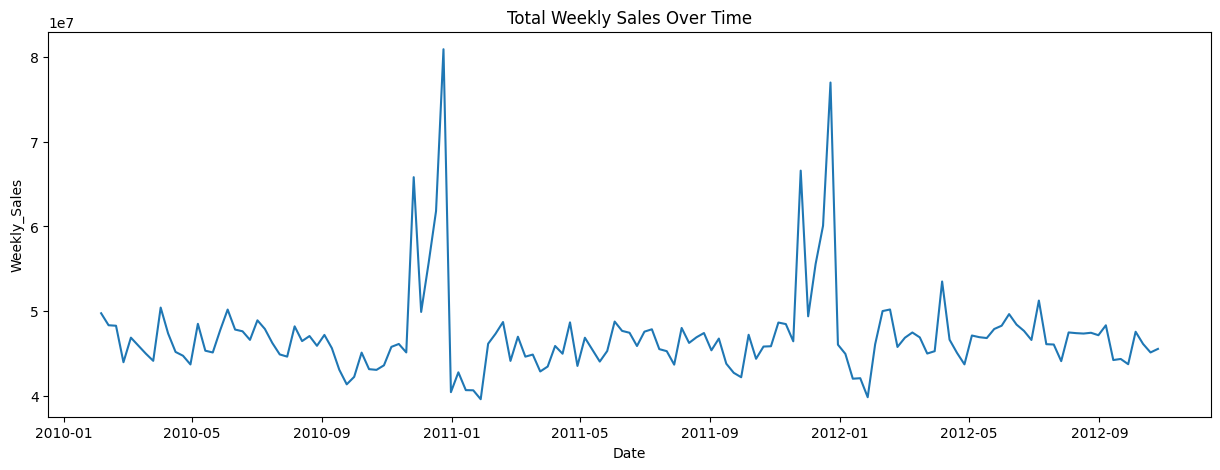

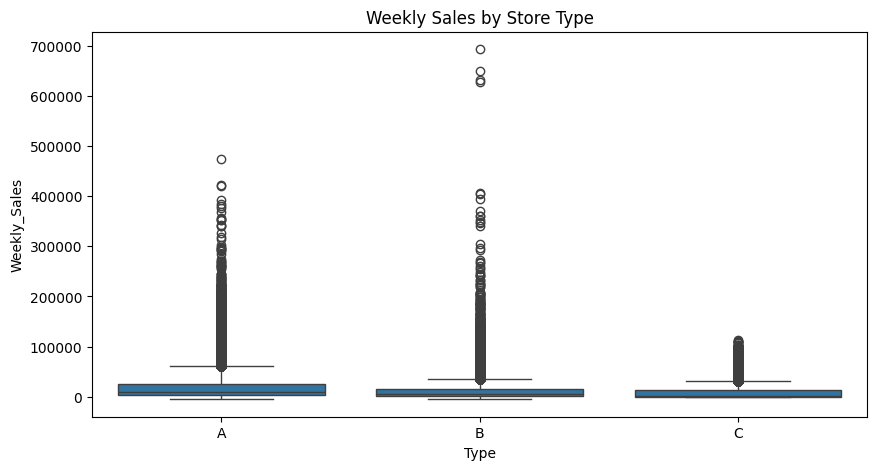

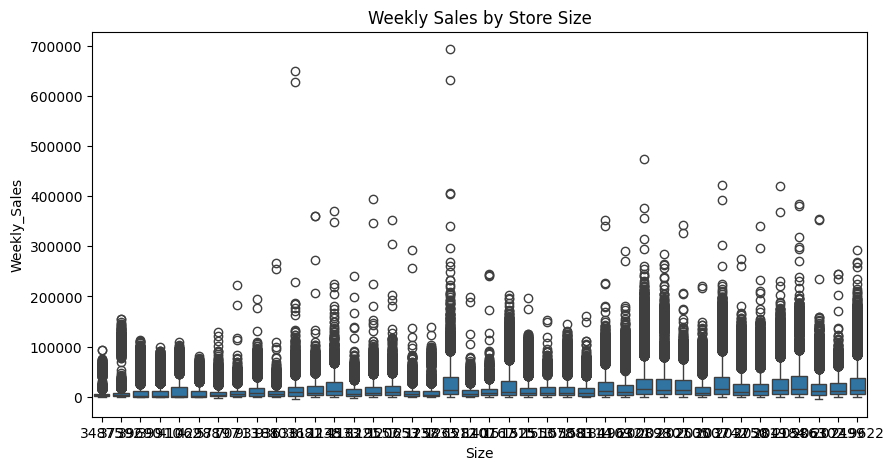

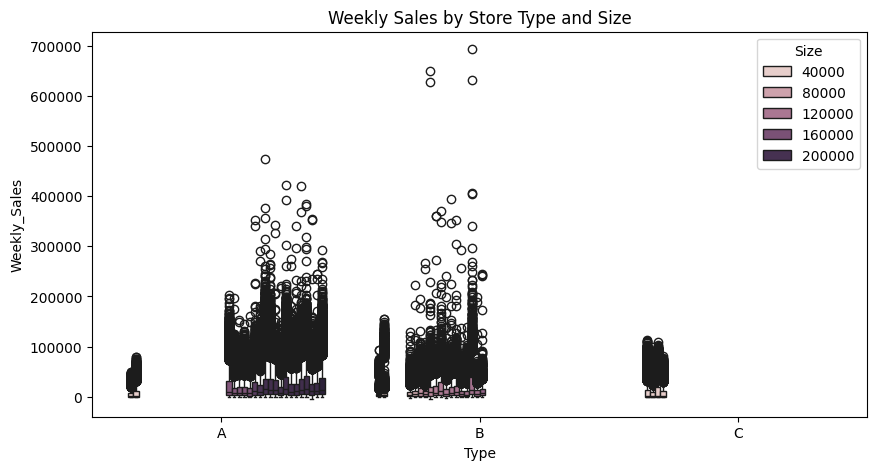

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating visualizations and saving to outputs folder...\n")

# Total sales over time
df_grouped = df.groupby("Date")["Weekly_Sales"].sum().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(x="Date", y="Weekly_Sales", data=df_grouped)
plt.title("Total Weekly Sales Over Time")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '01_sales_over_time.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 01_sales_over_time.png")

# Sales by store type
plt.figure(figsize=(10,5)) 
sns.boxplot(x="Type", y="Weekly_Sales", data=df)
plt.title("Weekly Sales by Store Type")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '02_sales_by_store_type.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 02_sales_by_store_type.png")

# Sales by store size
plt.figure(figsize=(10,5))  

sns.boxplot(x="Size", y="Weekly_Sales", data=df)

plt.title("Weekly Sales by Store Size")print(f"✓ Summary statistics saved to: summary_statistics.csv")

plt.tight_layout()summary_stats.to_csv(os.path.join(output_dir, 'summary_statistics.csv'))

plt.savefig(os.path.join(output_dir, '03_sales_by_store_size.png'), dpi=300, bbox_inches='tight')summary_stats = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe()

plt.show()# Save summary statistics

print("✓ Saved: 03_sales_by_store_size.png")

print(f"\nAll visualizations saved to: {output_dir}")

# Sales by store type and size

plt.figure(figsize=(10,5))print("✓ Saved: 04_sales_by_type_and_size.png")

sns.boxplot(x="Type", y="Weekly_Sales", hue="Size", data=df)plt.show()

plt.title("Weekly Sales by Store Type and Size")plt.savefig(os.path.join(output_dir, '04_sales_by_type_and_size.png'), dpi=300, bbox_inches='tight')
plt.tight_layout()